# 2025-10-15 Spline interpolation

* Accuracy of piecewise constant interpolation

* Piecewise polynomial methods

* Splines

* Libraries

See the [FNC](https://fncbook.com/overview-4)

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

# And our "bad" function
runge(x) = 1 / (1 + 10*x^2)

# And a utility for points distributed via cos
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

# And a helper for looking at conditioning
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

### Chebyshev interpolating polynomials

$$ \begin{split}\begin{split}
T_0 \left( x \right) &= 1 \\
T_1 \left( x \right) &= x \\
T_{n+1} \left( x \right) &= 2 x T_n \left( x \right) - T_{n-1} \left( x \right)
\end{split}\end{split} $$

In [2]:
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

vander_chebyshev (generic function with 2 methods)

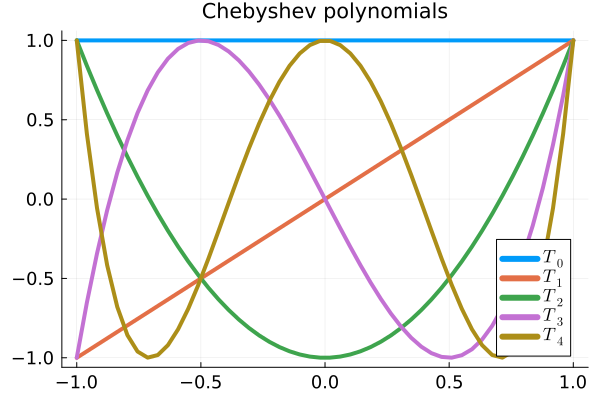

In [3]:
x = LinRange(-1, 1, 50) 
plot(x, vander_chebyshev(x, 5), title="Chebyshev polynomials", label=["\$T_0\$" "\$T_1\$" "\$T_2\$" "\$T_3\$" "\$T_4\$"])

### Well-conditioned

The Chebyshev polynomials are well-conditioned.

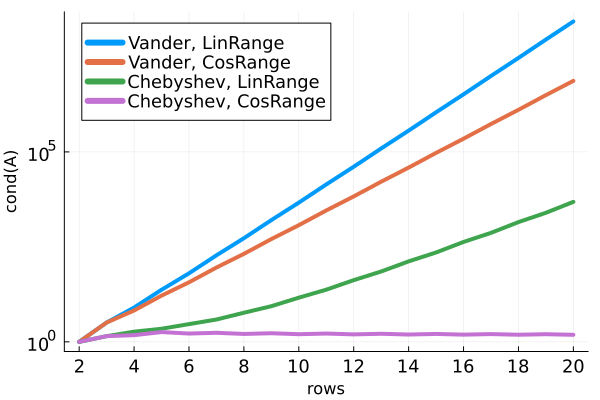

In [4]:
a = 20
plot(range(2, a), [vcond(vander, LinRange, a)], yscale=:log10, legend=:topleft, xticks=range(2, a, step=2), xlabel="rows", ylabel="cond(A)", label="Vander, LinRange")
plot!(range(2, a), [vcond(vander, CosRange, a)], yscale=:log10, label="Vander, CosRange")
plot!(range(2, a), [vcond(vander_chebyshev, LinRange, a)], yscale=:log10, label="Chebyshev, LinRange")
plot!(range(2, a), [vcond(vander_chebyshev, CosRange, a)], yscale=:log10, label="Chebyshev, CosRange")

## Piecewise polynomials

Let's take a different approach.
We'll re-examine the Lagrange polynomials as we vary the points.

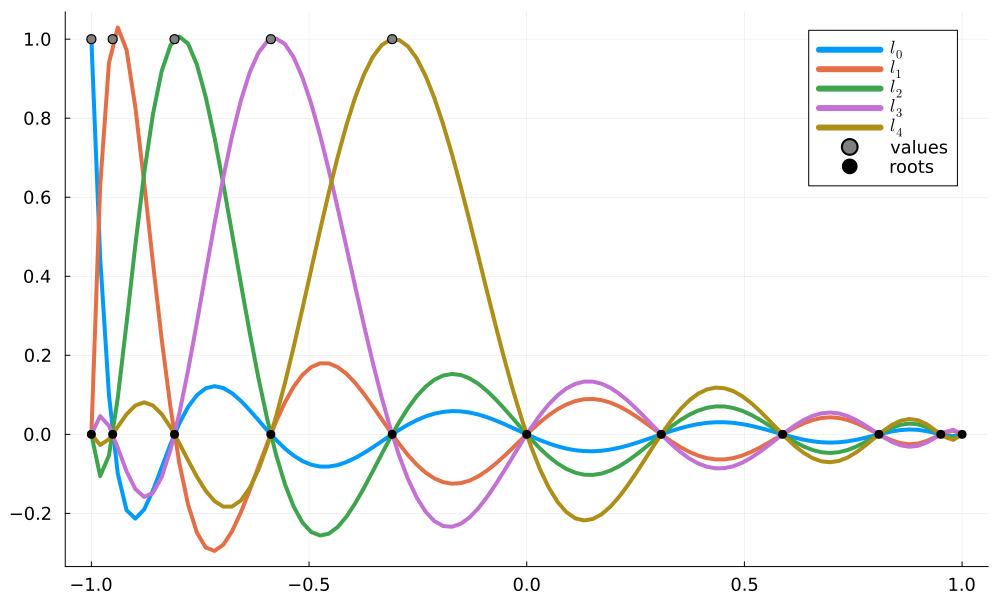

In [14]:
x = CosRange(-1, 1, 11) # What about LinRange?
s = LinRange(-1, 1, 100)
A = vander_chebyshev(s, length(x)) /
    vander_chebyshev(x)
plot(s, A[:,1:5], size=(1000, 600), label=["\$l_0\$" "\$l_1\$" "\$l_2\$" "\$l_3\$" "\$l_4\$"])
scatter!(x[1:5], ones(5), color=:grey, label="values")
scatter!(x, zero(x), color=:black, label="roots")

Let's look at a specific # Fit the function |x|
y = abs.(x)
plot(s, [abs.(s) A * y], label=["true" "fit"])example that seems like it should be easy to fit but shows strange behavior.

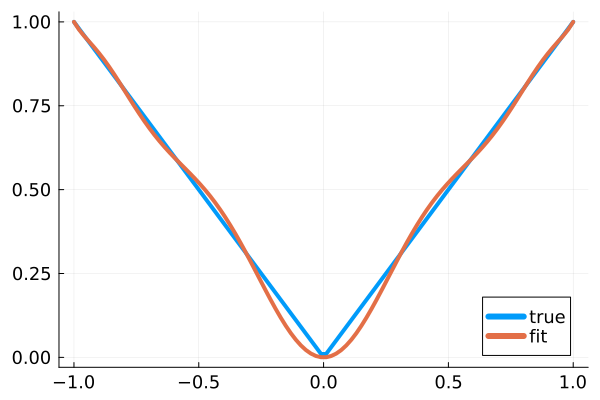

In [15]:
# Fit the function |x|
y = abs.(x)
plot(s, [abs.(s) A * y], label=["true" "fit"])

The effects of the higher order functions seem to be producing different behavior between the points we are fitting than we want.
The absolute value function looks like two linear functions glued together.
Let's try that.

### New interpolation matrix

In [16]:
function interp_nearest(x, s)
    A = zeros(length(s), length(x))
    for (i, t) in enumerate(s)
        loc = nothing
        dist = Inf
        for (j, u) in enumerate(x)
            if abs(t - u) < dist
                loc = j
                dist = abs(t - u)
            end
        end
        A[i, loc] = 1
    end
    A
end
interp_nearest(LinRange(-1, 1, 3), LinRange(0, 1, 4))

4×3 Matrix{Float64}:
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0

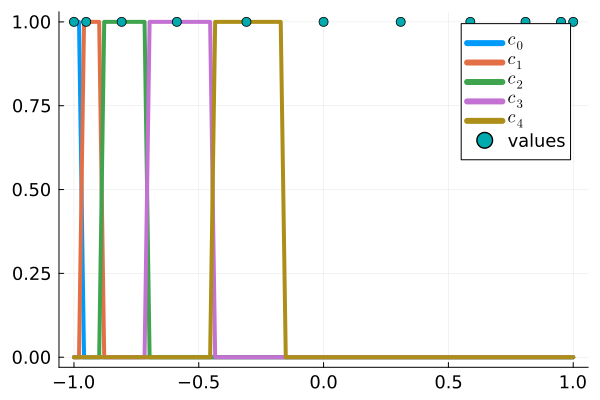

In [17]:
A = interp_nearest(x, s)
plot(s, A[:, 1:5], label=["\$c_0\$" "\$c_1\$" "\$c_2\$" "\$c_3\$" "\$c_4\$"])
scatter!(x, ones(length(x)), label="values")

Visually the accuracy seems reasonable.

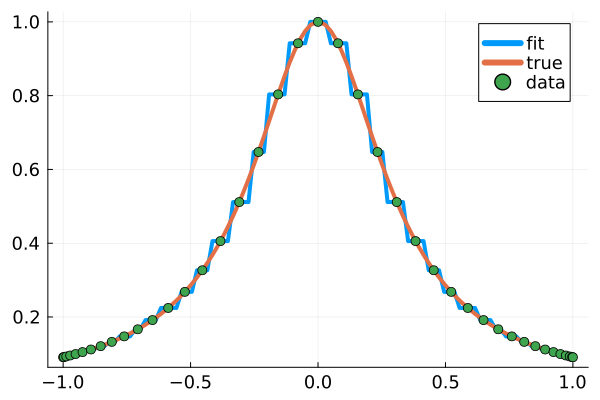

In [21]:
x = CosRange(-1, 1, 41)
A = interp_nearest(x, s)
plot(s, A * runge.(x), label="fit")
plot!(s, runge.(s), label="true")
scatter!(x, runge.(x), label="data")

This looks pretty good, but how accurate is it really?

In [22]:
function interp_chebyshev(x, xx)
    vander_chebyshev(xx, length(x)) * inv(vander_chebyshev(x))
end

function interp_monomial(x, xx)
    vander(xx, length(x)) * inv(vander(x))
end

function interp_error(ieval, x, xx, test)
    """Compute norm of interpolation error for function test
    using method interp_and_eval from points x to points xx.
    """
    A = ieval(x, xx)
    y = test.(x)
    yy = test.(xx)
    norm(A * y - yy, Inf)
end

function plot_convergence(ievals, ptspaces; xscale=:log10, yscale=:log10, maxpts=40)
    """Plot convergence rates for an interpolation scheme applied
    to a set of tests.
    """
    xx = LinRange(-1, 1, 100)
    ns = 2:maxpts
    fig = plot(title="Convergence",
        xlabel="Number of points",
        ylabel="Interpolation error",
        xscale=xscale,
        yscale=yscale,
        legend=:bottomleft,
        size=(1000, 700))
    for ieval in ievals
        for ptspace in ptspaces
            for test in [runge]
                errors = [interp_error(ieval, ptspace(-1, 1, n), xx, test)
                         for n in ns]
                plot!(ns, errors, marker=:circle, label="$ieval, $ptspace")
            end
        end
    end
    for k in [1, 2, 3]
        plot!(ns, ns .^ (-1.0*k), color=:black, label="\$n^{-$k}\$")
    end
    fig
end

plot_convergence (generic function with 1 method)

plot_convergence([interp_monomial, interp_chebyshev, interp_nearest], [LinRange, CosRange])

Piecewise interpolation seems to be not especially accurate, but it doesn't have the runaway Runge phenomenon.

### Observations

* Piecewise constant interpolation is **well-conditioned** on any set of points

* Piecewise constant interpolation **converges very slowly** (needs many points)

* Chebyshev/polynomial interpolation **requires special input points** otherwise it is **ill-conditioned**

* Chebyshev/polynomial interpolation has **"exponential" convergence** for 'smooth enough' functions

## Cubic Splines

If we are given an arbitrary distribution of points, interpolation with a single polynomial is not robust.
Piecewise constant interpolation is not very accurate and gives a rough function.
We could improve the accuracy by using a piecewise linear function, but the accuracy is still limited and the function still isn't smooth (there is a "corner" where the slope changes at each data point).
High(er)-order piecewise polynomial interpolation can be very useful, such as for finite element methods, but we will take a different direction here.

Splines are a way to guarantee an arbitrary amount of smoothness.
The idea is that given sorted input points $\left\lbrace x_i \right\rbrace_{i = 0}^n$, we compute an interpolating polynomial $s_i \left( x \right)$ on every interval $\left( x_i, x_{i + 1} \right)$.

This approach gives us a

* piecewise cubic function

* continuous values

* continuous derivatives

### Interpolation

Given a function value $y_i$ at each $x_i$, we require

$$ s_i \left( x_i \right) = y_i $$
$$ s_i \left( x_{i + 1} \right) = y_{i + 1} $$

so that the polynomial interpolates our data.
If the polynomial has order greater than 1, we are left with some extra degrees of freedom.
To provide a unique solution, we'll need to add conditions.

### Smoothness

The conditions above guarantee continuity, but not smoothness.
We use our extra degree(s) of freedom to impose smoothness conditions of the form

$$ s_i' \left( x_{i + 1} \right) = s_{i + 1}' \left( x_{i + 1} \right) $$
$$ s_i'' \left( x_{i + 1} \right) = s_{i + 1}'' \left( x_{i + 1} \right) $$

These conditions, which are applied at the interior nodes ($x = 1, \dots, n - 1$) couple the splines from adjacent intervals and causes the spline approximation to be globally coupled.

### End-point conditions

The conditions above are still not enough to guarantee a unique spline.
Suppose we use quadratic polynomials for each $s_i$.
Then with $n$ intervals, we have $n$ degrees of freedom after imposing the interpolation condition.
Meanwhile, there are only $n - 1$ internal nodes.
If we impose continuity of the first derivative, we have $n - \left( n - 1 \right) = 1$ undetermined degrees of freedom.
We could fix this by imposing a boundary condition, such as that the slope at one end-point (e.g., $s_0' \left( x_0 \right)$) was equal to a known value.
This is not symmetric and is often an unnatural condition.

Suppose we use cubic polynomials.
Now we have two degrees of freedom per interval after imposing the interpolation condition.
If we impose continuity of the first and second derivatives, we have $2n - 2 \left( n - 1 \right) = 2$
remaining degrees of freedom.
A common choice here is the "natural spline", $s_0'' \left( x_0 \right) = 0$ and $s_n'' \left( x_n \right) = 0$.
Cubic splines are the most popular spline in this family.